In [2]:
from pandas_datareader import data
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.framework import ops
import sklearn.preprocessing as preproc
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_excel("C:/Users/Administrator/Desktop/data.xlsx", sheet_name="Sheet1")
df

,Date,Low,High,Close,Open,Unnamed: 5,Unnamed: 6
0,1992-09-29,707.82,728.42,710.63,719.99,NaN,4620.0
1,1992-09-30,698.91,710.63,702.32,703.63,NaN,NaN
2,1992-10-05,668.90,702.32,679.62,676.47,NaN,NaN
3,1992-10-06,664.27,692.62,674.24,682.92,NaN,NaN
4,1992-10-07,664.43,676.84,665.26,676.56,NaN,NaN
...,...,...,...,...,...,...,...
6995,2021-06-11,3587.15,3614.40,3589.75,3614.11,NaN,NaN
6996,2021-06-15,3547.19,3592.95,3556.56,3587.47,NaN,NaN
6997,2021-06-16,3513.56,3561.09,3518.33,3556.71,NaN,NaN
6998,2021-06-17,3507.35,3534.20,3525.60,3508.32,NaN,NaN


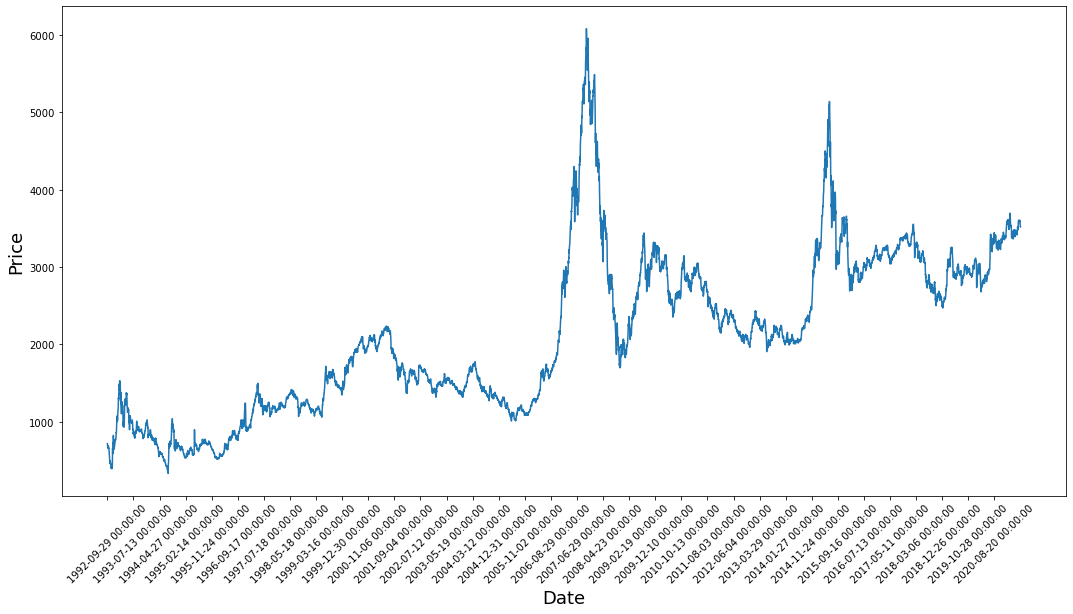

In [29]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],200),df["Date"].loc[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

In [5]:
# 首先用最高和最低价来算出中间价
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [6]:
scaler = MinMaxScaler()
mid_prices = mid_prices.reshape(len(mid_prices),-1)
scaler.fit(mid_prices)
mid_prices = scaler.transform(mid_prices)
mid_prices

array([[0.06707797],
       [0.06475622],
       [0.06142401],
       ...,
       [0.55737876],
       [0.55450047],
       [0.55426134]])

In [7]:
train_data = mid_prices[:4900] 
test_data = mid_prices[4900:]

In [8]:
# 将所有数据缩放到 0 和 1 之间
# 在缩放时请注意，缩放测试集数据时请使用缩放训练集数据的参数
# 因为在测试前你是不应当知道测试集数据的

train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
print(train_data)


[[0.06707797]
 [0.06475622]
 [0.06142401]
 ...
 [0.30995922]
 [0.30394786]
 [0.30056609]]


In [9]:
# 重新调整测试集和训练集
train_data = train_data.reshape(-1)
# 将测试集标准化
test_data = test_data.reshape(-1)


In [10]:
# 应用指数加权平均
# 现在数据将比之间更为平滑
EMA = 0.0
gamma = 0.1
for ti in range(4900):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# 用于可视化和调试
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [11]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
#         date = df.loc[pred_idx,'Date']
        date = df['Date'][pred_idx]
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00119


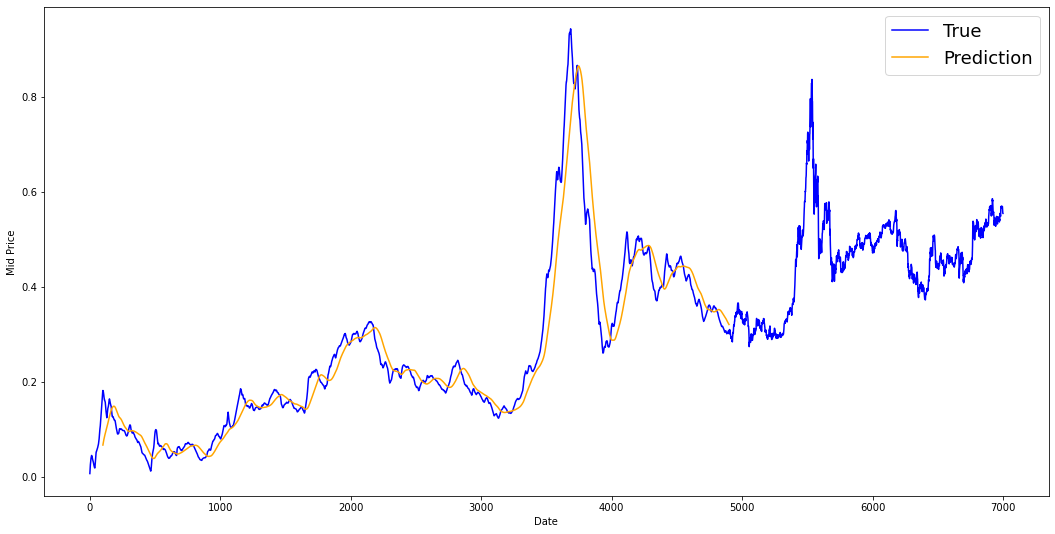

In [12]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [30]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00001


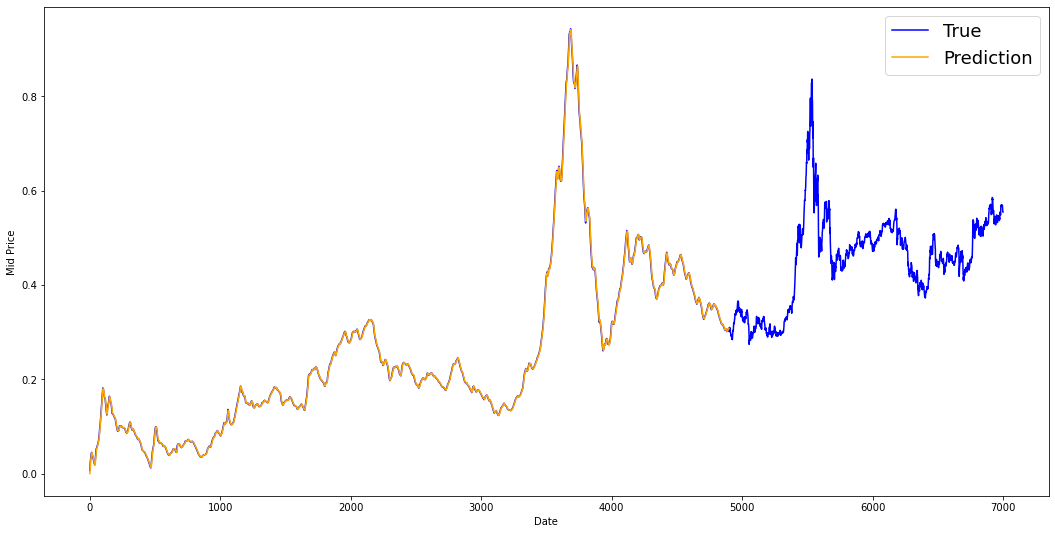

In [32]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [13]:
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.0067078  0.09083412 0.30113637 0.18386258 0.31126294]

	Output: [0.02539504 0.09038991 0.30023357 0.18530318 0.3077888 ]


Unrolled index 1
	Inputs:  [0.01251264 0.09038991 0.30023357 0.18453701 0.3077888 ]

	Output: [0.01740378 0.08896889 0.29805812 0.1852639  0.29806015]


Unrolled index 2
	Inputs:  [0.01740378 0.09007657 0.29914075 0.1847433  0.30465406]

	Output: [0.02539504 0.08689281 0.29805812 0.18530318 0.29806015]


Unrolled index 3
	Inputs:  [0.02168119 0.08970951 0.29805812 0.1848107  0.3020664 ]

	Output: [0.03432006 0.08689281 0.29627883 0.1843633  0.29806015]


Unrolled index 4
	Inputs:  [0.02539504 0.08896889 0.29627883 0.18530318 0.3004506 ]

	Output: [0.03432006 0.08689281 0.29249397 0.1852639  0.2875035 ]


定义超参数

下面将定义若干个超参数。D 是输入的维数。因为你使用前一天的股价来预测后面的股价，所以 D 应当是 1。

num_unrollings 表示单个步骤中考虑的连续时间点个数。

batch_size。它是在单个时间点中考虑的数据样本数量。它越大越好，因为选取的样本数量越大，模型可以参考的数据也就更多。

num_nodes 决定了每个单元中包含了多少隐藏神经元。在本例中，网络中包含三层 LSTM。

In [43]:
D = 1 # 数据的维度
num_unrollings = 50 # 你想预测多远的结果
batch_size = 50 # 一次批处理中包含的数据个数
num_nodes = [200,200,150] # 使用的深层 LSTM 网络的每一层中的隐藏节点数
n_layers = len(num_nodes) # 层数
dropout = 0.2 # dropout 概
ops.reset_default_graph()

定义输入和输出
接下来定义用于输入训练数据和标签的 placeholder。
每个 placeholder 中只包含一批一维数据，所以这并不难。对于每一个优化步骤，我们需要 num_unrollings 个 placeholder。

In [44]:
# 输入数据
train_inputs, train_outputs = [],[]

# 根据时间顺序展开输入，为每个时间点定义一个 placeholder
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

定义 LSTM 和回归层的参数
三层 LSTM 和一层线性回归层的神经网络，分别用 w 和 b 表示，它获取上一个长短期记忆单元的输出，并输出对下一个时间的预测。
使用 TensorFlow 中的 MultiRNNCell 来封装您创建的三个 LSTMCell 对象。
此外，LSTM 单元上还可以加上 dropout 来提高性能并减少过拟合。

In [45]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

计算 LSTM 输出并将结果代入回归层进行预测
首先创建 TensorFlow 张量 c 和 h 用来保存 LSTM 单元的单元状态和隐藏状态。
然后将 train_input 转换为 [num_unrollings, batch_size, D] 的形状，这是计算 tf.nn.dynamic_rnn 函数的输出所必需的。
然后用 tf.nn.dynamic_rnn 计算 LSTM 输出，并将输出转化为一系列 num_unrolling 张量来预测和真实股价之间的损失函数。

In [ ]:
首先创建TensorFlow变量(c和h)，这些变量将保存LSTM的单元格状态和隐藏状态。然后将TRANS_INPUT的列表转换为[num_unrolling，Batch_size，D]的形状，这是使用tf.n.DynamicRNN函数计算输出所需的。然后使用tf.nn.DynamicRNN函数计算LSTM输出，并将输出拆分回num_unroll张量列表。预测和真实股价之间的损失。

In [46]:
# 创建 LSTM 的单元状态 c 和隐藏状态 h
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# 因为 dynamic_rnn 函数需要特定的输出格式，所以我们对张量进行一些变换
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs 张量的尺寸是 [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

计算损失
对于每一批预测和真实输出，计算均方误差。你把所有这些均方损失加在一起(而不是平均)。
定义用于优化LSTM的优化器。在这里使用adam，这是一个最新的、性能良好的优化器。

In [47]:
# 在计算损失函数时，你需要注意准确的计算方法
# 因为你要同时计算所有展开步骤的损失函数
# 因此，在展开时取每批数据的平均误差，并将它们相加得到最终损失函数

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# 优化器
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients,v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


在此定义与预测相关的TensorFlow操作。
首先定义一个占位符，用于在输入中进行输入(Sample_Input)，然后类似于训练阶段，定义用于预测的状态变量(SAMPLE_c和SAMPLE_h)。
最后，使用tf.nn.DynamicRNN函数计算预测，然后通过回归层(w和b)发送输出。
还定义Reset_SAMPLE_STATE选项，它重置LSTM的单元格状态和隐藏状态。在每次进行一系列预测时，在开始时执行此操作。

In [48]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# 在预测阶段更新 LSTM 状态
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


运行LSTM
将训练和预测几个时段的指数走势，并观察随着时间的推移，预测会变得更好还是更糟。
按照以下步骤操作。
1.定义一组在时间序列上起始点(Test_Point_Seq)，以评估训练数据全序列长度的每个时期的LSTM值，展开一组num_unrolings批，用未滚动批训练LSTM，计算测试集中每个起点的平均训练损失，通过迭代测试点之前找到的num_unling数据点来更新LSTM状态，连续地对n_PRETER_1步骤进行预测，使用先前的预测，作为当前输入，计算n_PREPORT_一次性点与真实股票价格之间的MSE损失。

In [49]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(4900,7000,50).tolist() 
print(test_points_seq)

for ep in range(epochs):       
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:
        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))
      
        train_mse_ot.append(average_loss)
            
        average_loss = 0 # reset loss
      
        predictions_seq = []
      
        mse_test_loss_seq = []
      # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []
        
            if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
                x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)
            
            feed_dict = {}
        
            current_price = all_mid_data[w_i-1]
        
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):
                if w_i+pred_i >= 7000:
                    print('stop')
                    break
                pred = session.run(sample_prediction,feed_dict=feed_dict)
        
                our_predictions.append(np.asscalar(pred))
        
                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
            session.run(reset_sample_states)
            predictions_seq.append(np.array(our_predictions))
        
            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)
        
            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)
        
        current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
             loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0
      
        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

d:\progam\python3.7\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
[4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950]
Average loss at step 1: 0.181273



d:\progam\python3.7\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.00174
	Finished Predictions
Average loss at step 2: 0.023577

	Test MSE: 0.00368
	Finished Predictions
Average loss at step 3: 0.019712

	Test MSE: 0.00116
	Finished Predictions
Average loss at step 4: 0.017727

	Test MSE: 0.00136
	Finished Predictions
Average loss at step 5: 0.015878

	Test MSE: 0.00183
	Finished Predictions
Average loss at step 6: 0.015855

	Decreasing learning rate by 0.5
	Test MSE: 0.00141
	Finished Predictions
Average loss at step 7: 0.013207

	Test MSE: 0.00207
	Finished Predictions
Average loss at step 8: 0.012876

	Test MSE: 0.00164
	Finished Predictions
Average loss at step 9: 0.012975

	Decreasing learning rate by 0.5
	Test MSE: 0.00143
	Finished Predictions
Average loss at step 10: 0.012718

	Test MSE: 0.00108
	Finished Predictions
Average loss at step 11: 0.012435

	Test MSE: 0.00184
	Finished Predictions
Average loss at step 12: 0.011400

	Test MSE: 0.00108
	Finished Predictions
Average loss at step 13: 0.013159

	Decreasing learning rate by 0

LSTM预测可视化
可以看到MSE的损失是如何随着培训的数量下降，表明模型正在学习一些有用的东西。
为了量化研究结果，比较你在做标准平均时所得到的最小均方损耗。
可以看到，LSTM比标准平均做得更好，标准平均(虽然不是完美的)合理地遵循了真实的股票价格变动。

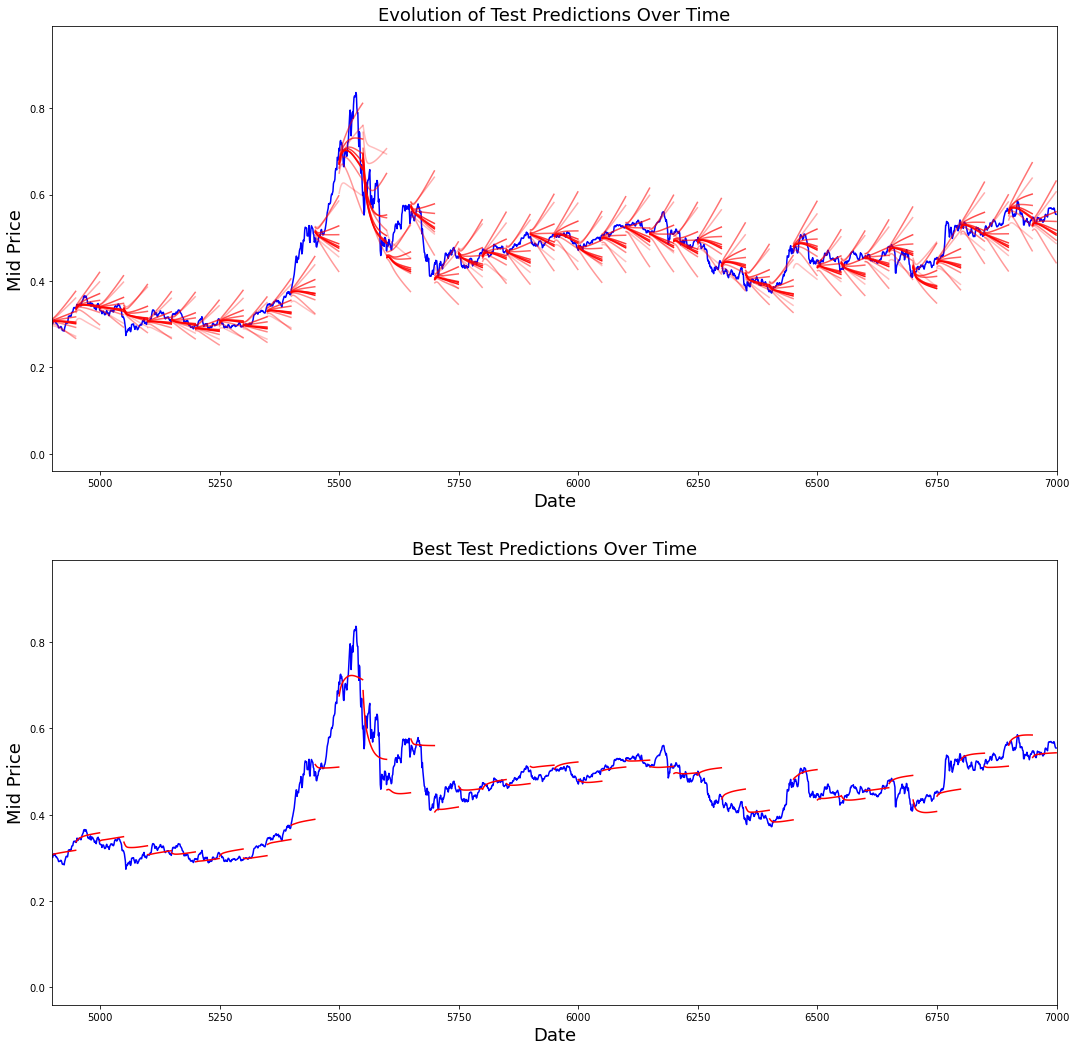

In [50]:
best_prediction_epoch = 29 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4900,7000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(4900,7000)
plt.show()